# Prediction of bioactivity from chemical structure
## Target: 5-HT2a  receptor

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!pip install rdkit-pypi

     |████████████████████████████████| 22.7 MB 1.5 MB/s 


In [5]:
from rdkit import Chem

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

In [7]:
# Loading dataset (ChEMBL Bioactivity database, "Target Name" == SEROTONIN)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Drug_discovery_course/Bioactivity_predictor/ChEMBL_5HT2A.csv', sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Exploring dataset

In [8]:
df

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL558551,NaN,0,258.23,0,0.09,(+)-THALIDOMIDE,O=C1CC[C@@H](N2C(=O)c3ccccc3C2=O)C(=O)N1,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909211,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,B,BAO_0000249,cell membrane format,None,None,None,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN
1,CHEMBL104,CLOTRIMAZOLE,4,344.85,1,5.38,CLOTRIMAZOLE,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,Ki,'=',3183.0,nM,5.50,NaN,NaN,UO_0000065,15.94,0.30,0.12,30.85,False,CHEMBL1909211,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,B,BAO_0000249,cell membrane format,None,None,None,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN
2,CHEMBL4742201,NaN,0,323.40,0,2.49,11,CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,Ki,'>',100000.0,nM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4669825,Binding affinity to 5HT2A receptor (unknown or...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4665756,1,Scientific Literature,Bioorg Med Chem Lett,2020.0,None,NaN
3,CHEMBL411,DIETHYLSTILBESTROL,4,268.36,0,4.83,DIETHYLSTILBESTROL,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,Ki,'=',1369.0,nM,5.86,NaN,NaN,UO_0000065,21.85,0.40,1.03,14.49,False,CHEMBL1909211,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,B,BAO_0000249,cell membrane format,None,None,None,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN
4,CHEMBL54126,NEOSTIGMINE BROMIDE,4,303.20,0,1.94,NEOSTIGMINE BROMIDE,CN(C)C(=O)Oc1cccc([N+](C)(C)C)c1.[Br-],IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909211,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,B,BAO_0000249,cell membrane format,None,None,None,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19328,CHEMBL683,CLOFIBRIC ACID,0,214.65,0,2.58,2,CC(C)(Oc1ccc(Cl)cc1)C(=O)O,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909211,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,B,BAO_0000249,cell membrane format,None,None,None,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN
19329,CHEMBL275854,NaN,0,190.25,0,1.76,29,CC(N)Cc1c[nH]c2ccc(O)cc12,Ki,'=',1.0,nM,9.00,NaN,NaN,UO_0000065,47.31,0.88,7.24,14.51,False,CHEMBL617920,In vitro inhibitory constant against [125I]DOI...,B,BAO_0000221,tissue-based format,Rattus norvegicus,CHEMBL3559724,Cerebral cortex,None,None,NaN,NaN,NaN,CHEMBL322,Serotonin 2a (5-HT2a) receptor,Rattus norvegicus,SINGLE PROTEIN,CHEMBL1145094,1,Scientific Literature,J. Med. Chem.,2

In [9]:
df.describe(include='all')

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
count,19333,3429,19333.00,19333,19333,19333,19333,19260,19333,16112,1.65e+04,15215,10793.00,161,4031,14271,9385.00,9385,9385,9385,19333,19333,19333,19333,19333,19333,19333,19333,19333,19333,19333,240,6,6,19333,19333,19333,19333,19333,19333.00,19333,16387,17353.00,19333,580
unique,12227,1265,NaN,5696,6,847,4666,12186,64,6,NaN,11,NaN,4,763,5,NaN,85,852,3149,2,1975,1713,4,9,9,11,25,25,31,7,15,1,1,17,9,7,4,1134,NaN,6,17,NaN,16,21
top,CHEMBL42,CLOZAPINE,NaN,326.83,0,None,9,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,Ki,'=',NaN,nM,NaN,Outside typical range,Not Active (inhibition < 50% @ 10 uM and thus ...,UO_0000065,NaN,0.33,None,None,False,CHEMBL1909211,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,Parental cells: HEKT | PMID: 16412547/ 2935410...,P28223,F340L,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,NaN,Scientific Literature,J. Med. Chem.,NaN,None,TIME = 1.0 hr
freq,118,118,NaN,140,16104,202,250,118,9395,14094,NaN,12850,NaN,109,1552,12405,NaN,424,55,56,18754,1742,1742,15736,6654,6654,8435,17238,17206,11856,17063,159,6,6,10983,15098,12192,15129,1742,NaN,16387,7533,NaN,13273,222
mean,NaN,NaN,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.56e+09,NaN,7.12,NaN,NaN,NaN,20.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.31,NaN,NaN,2006.51,NaN,NaN
std,NaN,NaN,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.17e+11,NaN,1.17,NaN,NaN,NaN,6.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.35,NaN,NaN,9.67,NaN,NaN
min,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.70e+01,NaN,4.00,NaN,NaN,NaN,5.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,1977.00,NaN,NaN
25%,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00e+01,NaN,6.24,NaN,NaN,NaN,15.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,1999.00,NaN,NaN
50%,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.50e+01,NaN,7.05,NaN,NaN,NaN,18.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,2008.00,NaN,NaN
75%,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00e+02,NaN,7.96,NaN,NaN,NaN,23.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,2014.00,NaN,NaN


In [10]:
df.dtypes

Molecule ChEMBL ID             object
Molecule Name                  object
Molecule Max Phase              int64
Molecular Weight               object
#RO5 Violations                object
AlogP                          object
Compound Key                   object
Smiles                         object
Standard Type                  object
Standard Relation              object
Standard Value                float64
Standard Units                 object
pChEMBL Value                 float64
Data Validity Comment          object
Comment                        object
Uo Units                       object
Ligand Efficiency BEI         float64
Ligand Efficiency LE           object
Ligand Efficiency LLE          object
Ligand Efficiency SEI          object
Potential Duplicate              bool
Assay ChEMBL ID                object
Assay Description              object
Assay Type                     object
BAO Format ID                  object
BAO Label                      object
Assay Organi

In [11]:
df.isnull().sum()

Molecule ChEMBL ID                0
Molecule Name                 15904
Molecule Max Phase                0
Molecular Weight                  0
#RO5 Violations                   0
AlogP                             0
Compound Key                      0
Smiles                           73
Standard Type                     0
Standard Relation              3221
Standard Value                 2790
Standard Units                 4118
pChEMBL Value                  8540
Data Validity Comment         19172
Comment                       15302
Uo Units                       5062
Ligand Efficiency BEI          9948
Ligand Efficiency LE           9948
Ligand Efficiency LLE          9948
Ligand Efficiency SEI          9948
Potential Duplicate               0
Assay ChEMBL ID                   0
Assay Description                 0
Assay Type                        0
BAO Format ID                     0
BAO Label                         0
Assay Organism                    0
Assay Tissue ChEMBL ID      

In [12]:
df['Standard Type'].value_counts().head(20)

Ki                    9395
IC50                  3733
EC50                  1340
Inhibition            1243
Activity               740
Emax                   449
Ratio                  396
Kd                     248
Selectivity            239
Ratio Ki               182
ED50                   174
Selectivity ratio      150
Intrinsic activity     124
-Log KB                100
Efficacy                85
Ratio EC50              63
pKB                     60
Ke                      60
p[A50]                  46
log(ratio)              44
Name: Standard Type, dtype: int64

## Selection of meaningful columns and rows

In [13]:
df_selected = df[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Value', 'Standard Units']]

In [14]:
df_selected

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units
0,CHEMBL558551,O=C1CC[C@@H](N2C(=O)c3ccccc3C2=O)C(=O)N1,Ki,NaN,NaN
1,CHEMBL104,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,Ki,3183.0,nM
2,CHEMBL4742201,CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,Ki,100000.0,nM
3,CHEMBL411,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,Ki,1369.0,nM
4,CHEMBL54126,CN(C)C(=O)Oc1cccc([N+](C)(C)C)c1.[Br-],IC50,NaN,NaN
...,...,...,...,...,...
19328,CHEMBL683,CC(C)(Oc1ccc(Cl)cc1)C(=O)O,Ki,NaN,NaN
19329,CHEMBL275854,CC(N)Cc1c[nH]c2ccc(O)cc12,Ki,1.0,nM
19330,CHEMBL275854,CC(N)Cc1c[nH]c2ccc(O)cc12,Efficacy,99.0,%
19331,CHEMBL275707,C[C@H]1CN(CCCn2c3ccccc3c3ccccc32)C[C@@H](C)N1,Ki,2482.0,nM


In [15]:
df_selected = df_selected[df_selected['Standard Units'].str.contains('nM', na=False)]

In [16]:
df_selected.isnull().sum()

Molecule ChEMBL ID      0
Smiles                  9
Standard Type           0
Standard Value        122
Standard Units          0
dtype: int64

In [17]:
df_selected.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [18]:
# there are many different activity values for the same molecule
df_selected['Molecule ChEMBL ID'].value_counts()

CHEMBL42         103
CHEMBL39          75
CHEMBL54          72
CHEMBL51          69
CHEMBL85          48
                ... 
CHEMBL53939        1
CHEMBL4465414      1
CHEMBL543613       1
CHEMBL313694       1
CHEMBL141209       1
Name: Molecule ChEMBL ID, Length: 9645, dtype: int64

In [19]:
# bias in activity, on example of most tested mocelule CHEMBL42
df_selected[df_selected['Molecule ChEMBL ID'].str.fullmatch('CHEMBL42')].describe()

,Standard Value
count,103.00
mean,15.20
std,24.99
min,0.69
25%,5.72
50%,9.40
75%,14.25
max,230.00


In [20]:
# handling bias in activity data from differen assays: 
# calculationg average activity (mean_value)

df_selected['mean_value'] = df_selected.groupby('Molecule ChEMBL ID')['Standard Value'].transform('mean')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [21]:
df_selected.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units,mean_value
1,CHEMBL104,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,Ki,3183.0,nM,7162.5
2,CHEMBL4742201,CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,Ki,100000.0,nM,100000.0
3,CHEMBL411,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,Ki,1369.0,nM,3079.5
6,CHEMBL900,Cc1ccccc1C(OCCN(C)C)c1ccccc1,IC50,436.0,nM,280.5
11,CHEMBL55,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,IC50,1639.0,nM,1053.5


In [22]:
# well-studied substances (tested for activity in more than 10 assays)

frequent_bounders = df_selected.groupby('Molecule ChEMBL ID').filter(lambda x: len(x) > 10)
frequent_bounders

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units,mean_value
37,CHEMBL39,NCCc1c[nH]c2ccc(O)cc12,EC50,2.34,nM,959.24
63,CHEMBL42,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,Ki,4.84,nM,15.20
64,CHEMBL715,Cc1cc2c(s1)Nc1ccccc1N=C2N1CCN(C)CC1,Ki,2.50,nM,10.81
65,CHEMBL6607,COc1cc(CC(C)N)c(OC)cc1Br,Ki,22.00,nM,31.49
99,CHEMBL54,O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1,Ki,27.00,nM,89.61
...,...,...,...,...,...,...
19318,CHEMBL54,O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1,Ki,108.00,nM,89.61
19319,CHEMBL54,O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1,IC50,129.00,nM,89.61
19320,CHEMBL56,CCCN(CCC)C1CCc2cccc(O)c2C1,IC50,10000.00,nM,7119.06
19322,CHEMBL54,O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1,Ki,164.00,nM,89.61


In [23]:
df_selected.drop(['Standard Type', 'Standard Value', 'Standard Units'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
df_selected.drop_duplicates('Molecule ChEMBL ID', keep='first', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [25]:
df_selected.head()

,Molecule ChEMBL ID,Smiles,mean_value
1,CHEMBL104,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,7162.5
2,CHEMBL4742201,CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,100000.0
3,CHEMBL411,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,3079.5
6,CHEMBL900,Cc1ccccc1C(OCCN(C)C)c1ccccc1,280.5
11,CHEMBL55,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,1053.5


In [26]:
from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames(images=True)

In [27]:
PandasTools.AddMoleculeColumnToFrame(df_selected,'Smiles','MOL',includeFingerprints=False)

/usr/local/lib/python3.7/dist-packages/rdkit/Chem/PandasTools.py:449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,Molecule ChEMBL ID,Smiles,mean_value,MOL
1,CHEMBL104,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,7162.5,
2,CHEMBL4742201,CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,100000.0,
3,CHEMBL411,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,3079.5,
6,CHEMBL900,Cc1ccccc1C(OCCN(C)C)c1ccccc1,280.5,
11,CHEMBL55,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,1053.5,
...,...,...,...,...
19229,CHEMBL307717,CN1CCN(C2CC(c3ccc(F)cc3)c3ccc(F)cc32)CC1,7.7,
19237,CHEMBL428999,Brc1ccc2c3c([nH]c2c1)C=NCC3,1330.0,
19273,CHEMBL4759887,CN1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2C1=O,215.9,
19310,CHEMBL494678,CN1CCN(c2cc(-c3ccc(C#N)cc3)nc(N)n2)CC1,4100.0,

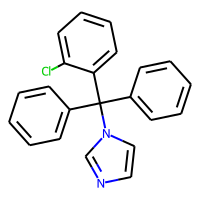
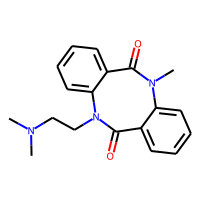
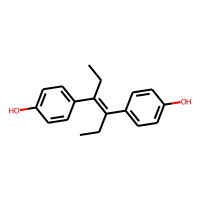
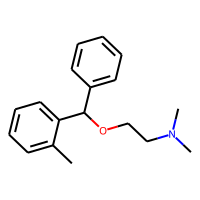
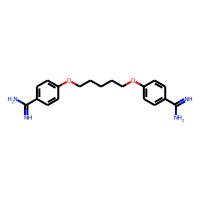
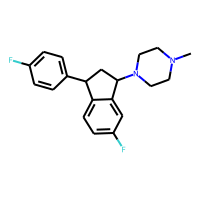
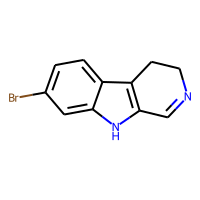
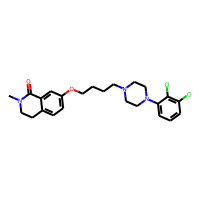
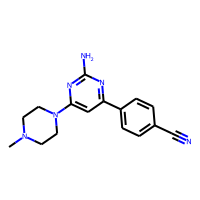
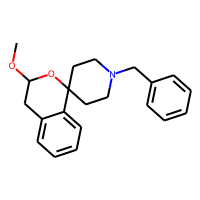

In [28]:
df_selected

## Standardization of structures using MolVS 
(based on RDKit.MolStandardize module, see https://molvs.readthedocs.io/en/latest/guide/standardize.html)

In [29]:
!pip install molvs


     |████████████████████████████████| 61 kB 441 kB/s 
  Created wheel for molvs: filename=MolVS-0.1.1-py3-none-any.whl size=32387 sha256=62dff438320c372179556b726648f4ad90da3276743b8b992bdfd34191712f67
  Stored in directory: /root/.cache/pip/wheels/c4/c2/92/e85190307603c2b3733d43e357abae2d1c66b609bfbba6200d
Successfully built molvs


In [32]:
from molvs import Standardizer
s = Standardizer()

df_selected['MOL_standardized'] = df_selected['MOL'].apply(s.standardize)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Molecule ChEMBL ID,Smiles,mean_value,MOL,MOL_standardized
1,CHEMBL104,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,7162.5,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
2,CHEMBL4742201,CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,100000.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
3,CHEMBL411,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,3079.5,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
6,CHEMBL900,Cc1ccccc1C(OCCN(C)C)c1ccccc1,280.5,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
11,CHEMBL55,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,1053.5,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

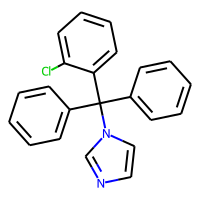
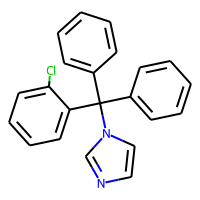
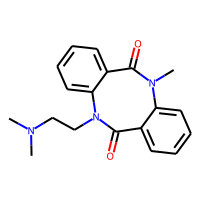
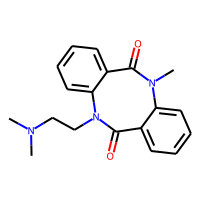
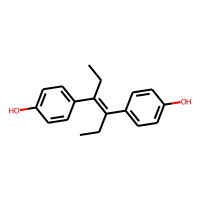
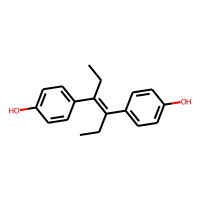
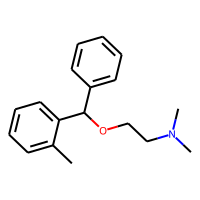
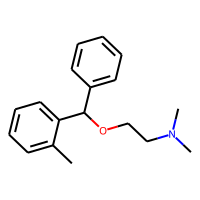
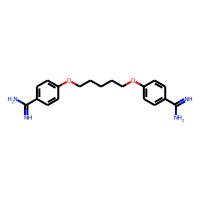
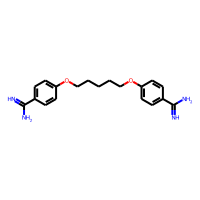

In [33]:
df_selected.head()

In [34]:
df_selected['Smiles_standard'] = df_selected['MOL_standardized'].apply(Chem.MolToSmiles)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
# dataset with just chemical structure and one activity value per substanse
df_selected.columns

Index(['Molecule ChEMBL ID', 'Smiles', 'mean_value', 'MOL', 'MOL_standardized',
       'Smiles_standard'],
      dtype='object')

In [36]:
df_selected.nunique()

Molecule ChEMBL ID    9645
Smiles                9645
mean_value            3963
MOL                   9645
MOL_standardized      9645
Smiles_standard       9645
dtype: int64

## Data labeling based on activity:

* Class 0: '**weak**'. Active at  > 10000 nM
* Class 1: '**mild**'. Active between 1000 nM and 10000 nM
* Class 2: '**strong**'. Active between 100 nM and 1000 nM
* Class 3: '**very strong**' Active at < 100 nM 


In [37]:
conditions_activity = [(df_selected.mean_value <= 100), 
                       ((df_selected.mean_value > 100) & (df_selected.mean_value <= 1000)), 
                       ((df_selected.mean_value > 1000) & (df_selected.mean_value <= 10000)), 
                       (df_selected.mean_value > 10000)]
labels_activity = ['very strong', 
                   'strong', 
                   'mild', 
                   'weak']
df_selected['Activity'] = np.select(conditions_activity, labels_activity)

labels = [3, 2, 1, 0] 
df_selected['Label'] = np.select(conditions_activity, labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Molecule ChEMBL ID,Smiles,mean_value,MOL,MOL_standardized,Smiles_standard,Activity,Label
1,CHEMBL104,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,7162.5,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,mild,1
2,CHEMBL4742201,CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,100000.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,weak,0
3,CHEMBL411,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,3079.5,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,mild,1
6,CHEMBL900,Cc1ccccc1C(OCCN(C)C)c1ccccc1,280.5,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",Cc1ccccc1C(OCCN(C)C)c1ccccc1,strong,2
11,CHEMBL55,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,1053.5,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,mild,1
...,...,...,...,...,...,...,...,...
19229,CHEMBL307717,CN1CCN(C2CC(c3ccc(F)cc3)c3ccc(F)cc32)CC1,7.7,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CN1CCN(C2CC(c3ccc(F)cc3)c3ccc(F)cc32)CC1,very strong,3
19237,CHEMBL428999,Brc1ccc2c3c([nH]c2c1)C=NCC3,1330.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",Brc1ccc2c3c([nH]c2c1)C=NCC3,mild,1
19273,CHEMBL4759887,CN1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2C1=O,215.9,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CN1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2C1=O,strong,2
19310,CHEMBL494678,CN1CCN(c2cc(-c3ccc(C#N)cc3)nc(N)n2)CC1,4100.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CN1CCN(c2cc(-c3ccc(C#N)cc3)nc(N)n2)CC1,mild,1

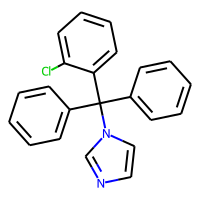
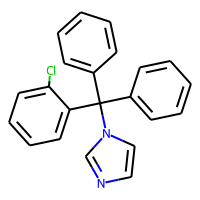
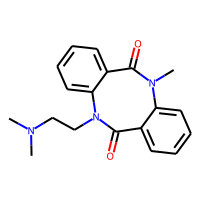
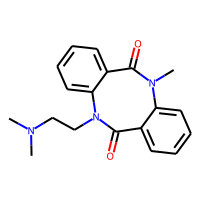
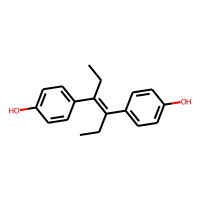
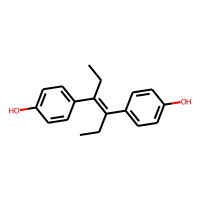
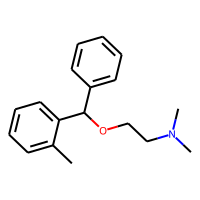
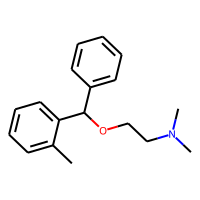
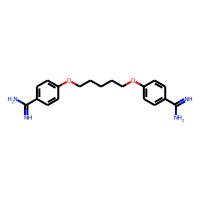
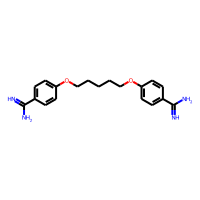
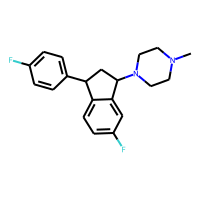
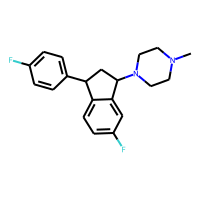
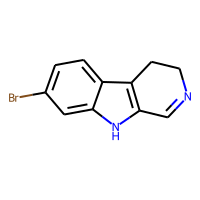
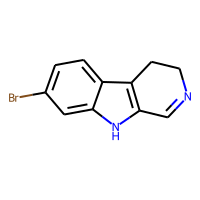
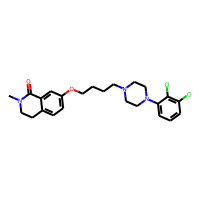
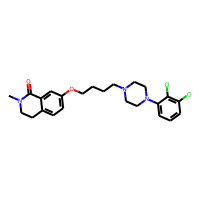
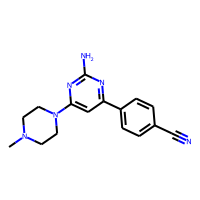
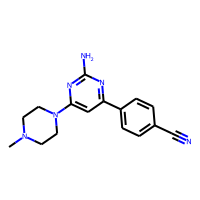
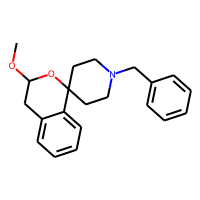
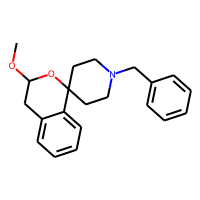

In [38]:
df_selected

In [ ]:
df_selected.columns

Index(['Molecule ChEMBL ID', 'Smiles', 'mean_value', 'MOL', 'MOL_standardized',
       'Smiles_standard', 'Activity', 'Label'],
      dtype='object')

In [39]:
df_selected[['Molecule ChEMBL ID', 'Smiles_standard', 'mean_value', 'Activity', 'Label']]\
.to_csv('/content/drive/MyDrive/Colab Notebooks/Drug_discovery_course/Bioactivity_predictor/serotonin_labeled.csv', index=None)

In [40]:
df_selected.drop(['Smiles', 'MOL'], axis = 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [41]:
df_selected['Activity'].value_counts(normalize=True)

very strong    0.42
strong         0.31
mild           0.23
weak           0.04
Name: Activity, dtype: float64

Text(0, 0.5, 'Count')

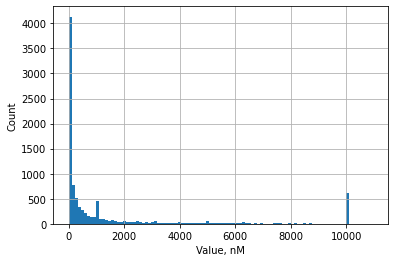

In [42]:
df_selected[df_selected.mean_value < 11000]['mean_value'].hist(bins=100)
plt.xlabel('Value, nM')
plt.ylabel('Count')

In [43]:
# final dataset to train the model
to_use = df_selected[['Smiles_standard', 'Label']]

In [44]:
to_use

,Smiles_standard,Label
1,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,1
2,CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,0
3,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,1
6,Cc1ccccc1C(OCCN(C)C)c1ccccc1,2
11,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,1
...,...,...
19229,CN1CCN(C2CC(c3ccc(F)cc3)c3ccc(F)cc32)CC1,3
19237,Brc1ccc2c3c([nH]c2c1)C=NCC3,1
19273,CN1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2C1=O,2
19310,CN1CCN(c2cc(-c3ccc(C#N)cc3)nc(N)n2)CC1,1


In [45]:
to_use.to_csv('/content/drive/MyDrive/Colab Notebooks/Drug_discovery_course/Bioactivity_predictor/serotonin_labeled.smi', header=None, index=None, sep='\t')

## Transformation of molecular structure into bit vector 
### (using Morgan Fingerprints)

In [ ]:
to_use = pd.read_csv('serotonin_labeled.smi', header=None, sep='\t')
to_use

,0,1
0,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,1
1,CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,0
2,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,1
3,Cc1ccccc1C(OCCN(C)C)c1ccccc1,2
4,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,1
...,...,...
9640,CN1CCN(C2CC(c3ccc(F)cc3)c3ccc(F)cc32)CC1,3
9641,Brc1ccc2c3c([nH]c2c1)C=NCC3,1
9642,CN1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2C1=O,2
9643,CN1CCN(c2cc(-c3ccc(C#N)cc3)nc(N)n2)CC1,1


In [47]:
from rdkit import Chem, rdBase
from rdkit.Chem import AllChem, Draw, MolStandardize
from rdkit.Chem.Draw import IPythonConsole

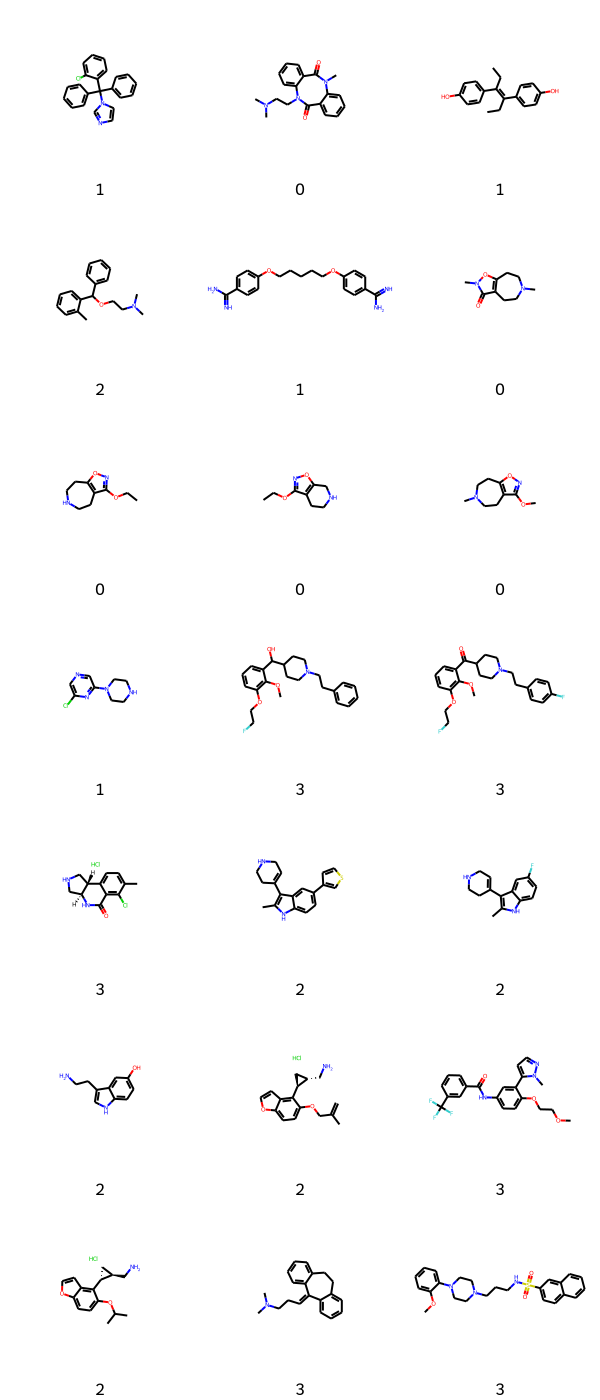

In [48]:
# draw first 21 structures 
Draw.MolsToGridImage([Chem.MolFromSmiles(smix) for smix in to_use.iloc[0:21, 0] if smix is not None],
                    legends=[str(label) for label in to_use.iloc[0:21, 1] if label is not None])

In [49]:
smiles = Chem.SmilesMolSupplier('/content/drive/MyDrive/Colab Notebooks/Drug_discovery_course/Bioactivity_predictor/serotonin_labeled.smi', delimiter='\t', titleLine=False)

In [50]:
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits = 2048) for mol in smiles if mol is not None]

In [51]:
all_data = np.asarray(fingerprints, dtype=int)

In [52]:
all_data[20:50]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [53]:
all_data.shape

(9645, 2048)

In [54]:
ids=[mol.GetProp('_Name') for mol in smiles if mol is not None]

In [55]:
labels=np.asarray(ids, dtype=int).reshape(-1,1)

In [56]:
labels

array([[1],
       [0],
       [1],
       ...,
       [2],
       [1],
       [1]])

In [57]:
final_data=np.concatenate([all_data, labels], axis=1)

In [58]:
final_data

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [59]:
np.save('/content/drive/MyDrive/Colab Notebooks/Drug_discovery_course/Bioactivity_predictor/serotonin_morgan', final_data)

## Preparation for model training

In [60]:
from sklearn.model_selection import train_test_split

# TO DO! Split based on Clustering of Murcko Scaffolds must be used instead of random split

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(all_data, labels.ravel(), random_state=0, shuffle=True, stratify=labels)

In [ ]:
X_train.shape

(7233, 2048)

In [ ]:
X_test.shape

(2412, 2048)

## Models evaluations

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
knn = KNeighborsClassifier()
rf = RandomForestClassifier(max_depth=10, n_estimators = 500)
lin_svc = LinearSVC(random_state=42, max_iter=4000)
svc = SVC(gamma='scale', random_state=42)


In [ ]:
estimators = {
    'KNeighborsClassifier': knn,
    'Random forest': rf,
    'LinearSVC': lin_svc,
    'SVC': svc}

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=500)

In [ ]:
lin_svc.fit(X_train, y_train)

LinearSVC(max_iter=4000, random_state=42)

In [ ]:
svc.fit(X_train, y_train)

SVC(random_state=42)

KNeighborsClassifier: train score=78.10%; test score=65.88%


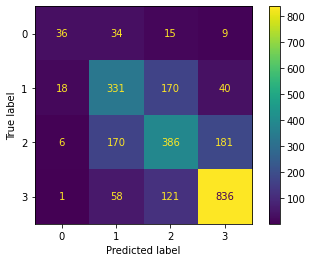




       Random forest: train score=68.05%; test score=58.42%


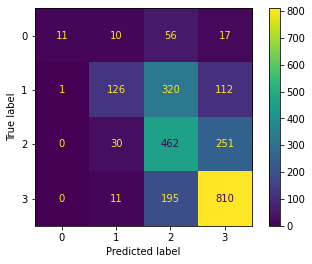




           LinearSVC: train score=88.18%; test score=64.34%


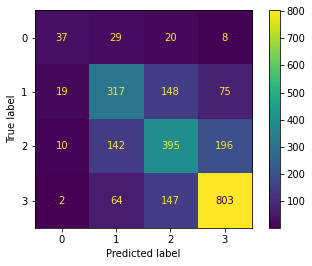




                 SVC: train score=80.99%; test score=67.29%


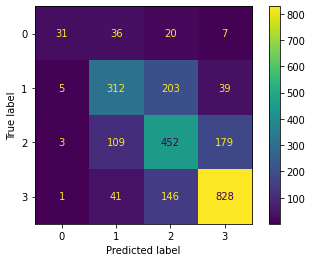

In [ ]:
for estimator_name, estimator_object in estimators.items():
    print(f'{estimator_name}: ' +
          f'train score={estimator_object.score(X_train, y_train):.2%}; ' +
          f'test score={estimator_object.score(X_test, y_test):.2%}')
   
    cm = metrics.confusion_matrix(y_test, 
                          estimator_object.predict(X_test), 
                          labels=estimator_object.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=estimator_object.classes_)
    disp.plot()
    plt.show()
    print()
    print()
    print()

## testing of model on unknown molecules

In [ ]:
# test data input 
input_mol = input('Enter molecular structure in SMILE format:')
# input_mol = standardize_smiles('CNC(C)Cc1ccc2c(c1)OCO2')


Enter molecular structure in SMILE format:CNC(C)Cc1ccc2c(c1)OCO2


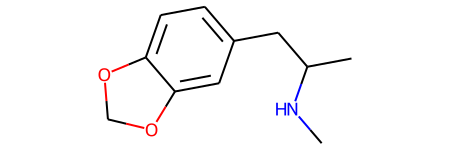

In [ ]:
# draw entered molecule
Chem.MolFromSmiles(input_mol)

In [ ]:
mol_test = Standardizer().standardize(Chem.MolFromSmiles(input_mol))
fingerprint_test = rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(mol_test,2,nBits = 2048)
data_test = np.asarray(fingerprint_test, dtype=int).reshape(1,2048)

In [ ]:
data_test

array([[0, 1, 0, ..., 0, 0, 0]])

In [ ]:
for estimator_name, estimator_object in estimators.items():
    class_predicted = estimator_object.predict(data_test).tolist()
    print(f'{estimator_name:>20}: {class_predicted}')

KNeighborsClassifier: [1]
       Random forest: [2]
           LinearSVC: [1]
                 SVC: [1]


In [ ]:
knn.predict_proba(data_test).tolist()

[[0.0, 0.6, 0.4, 0.0]]

In [ ]:
rf.predict_proba(data_test).tolist()

[[0.057011915352953524,
  0.30661207803991514,
  0.34247118914970354,
  0.2939048174574279]]

# TO DO:
# SCREENING: predictions for DrugBank Drugs

In [ ]:
db=np.load('drugbank.npy', allow_pickle=True)

In [ ]:
db_f=db[0:,0:2048]

In [ ]:
db_id=db[0:,2048]

In [ ]:
db_predicted = rf.predict(db_f)

In [ ]:
db_df = pd.DataFrame(db.predict, columns='predicted_class')
db_labels = pd.DataFrame(db_id, columns='drug_name')

In [ ]:
db_pred = np.concat([db_df, db_labels], axis = 1)

In [ ]:
db_positive = db_pred.loc[db_pred.predicted_class == 1]